<a href="https://colab.research.google.com/github/linked0/deep-learning/blob/master/AAMY/image_classification_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Convolutional Neural Networks

In this tutorial, we'll build and train a neural network to classifiy images of clothing, like sneakers and shirts.
It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, withh explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.
This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies
We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries..

In [1]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 686kB 3.5MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

# This will go away in the future.
# If this gives an error, you mighjt be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


## Import the Fashion MNIST dataset
This guide uses the [Fashion MNIST](https://github.com/zalandorearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution(28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png" alt="Fashion MNIST sprite" width="600">
    </td></tr>
  <tr><td align="center">
    <b>Figure 1</b> <a href="https://github.com/zaladoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
    </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset -- often used as the "Hello, World" of mechine learning programs for computer vision. The MNIST dataset contains images of handwritten digits(0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more chhallenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurateoy the network learned to classify images. You can access thhe Fashion MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Explore the data
Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


## Preporcess the data
The value of each pixel in the image data is an integer in the range [0, 255]. For the model to work properly, these values need tob e normalized to the range [0, 1]. So here we create a normalization function, and then apply it to each image in the test and train datasets..

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to eachh element in the train 
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

### Explore the processed data
Let's plot an image to see what it looks like.

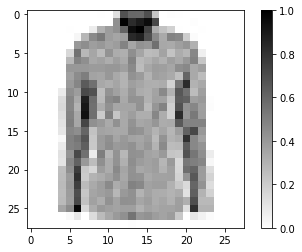

In [7]:
# Take an single image, and remove the color dimensioin by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

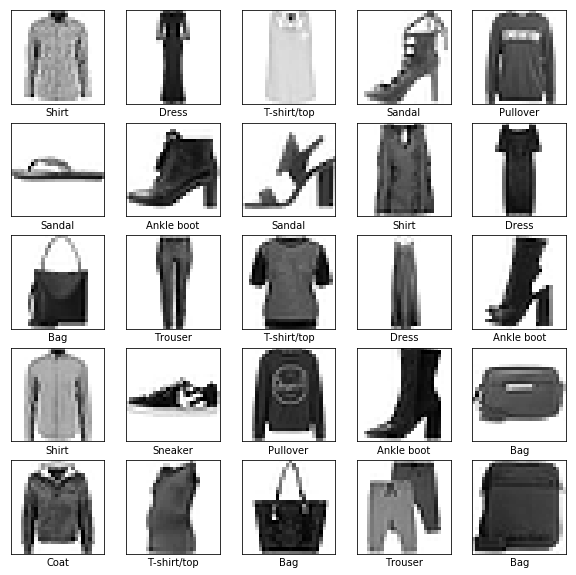

In [8]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

## Build the model
Building the nueral network requires configuring the layers of the model, the compling the model.

### Setup the layers
The basic building block of a neural network is the layer. A layer extracts a representation from th data fed into it. Hopefully, a series of connected layers results in representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                          input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

This network layers are:

* "convolutions" `tf.keras.layers.Conv2D` and `MaxPooling2D`-- Network start with pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output(convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 oupts are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes 32 images as input and and creates 64 outputs whichh are again reduced in siz e by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` -- A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0,1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

### Compile the model
Before the model is ready for training, it needs a few more setting. These are added during the model's *compile* step:

* *Loss function* -- An algorithm for measuring how far the model's outpus are from the desired output. Thhe goal of training is this measures loss..
* *Optimizer* --Used to monitor the training and testing steps. Thhe following example uses *accuracy*, the faction of the images that are correctly classified.

In [0]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Train the model
First, we define the iteration behavior for the train dataset:

1. Repeat forever by specifying `dataset.repeat()`(the `epochs` parameter described below limits how long we perform training)
2. The `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling thhe `model.fit` method: 

1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 exmples..

(Don't worry about `steps_per_epoch`, the requirement to have thhis flag will soon be removed)

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.4016 - acc: 0.8546
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2586 - acc: 0.9061
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2105 - acc: 0.9227
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1828 - acc: 0.9324
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1561 - acc: 0.9416
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1337 - acc: 0.9510
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1098 - acc: 0.9594
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0913 - acc: 0.9671
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0800 - acc: 0.9707
Epoch 10/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0652 - acc: 0.9757


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97(or 97%) on the training data

## Evaluate accuracy
Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset: ', test_accuracy)

313/313 [==============================] - 2s 8ms/step - loss: 0.3223 - acc: 0.9231
Accuracy on test dataset:  0.9231


In [14]:
num_test_examples/32

312.5

As it turns out, thhe accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sess images it has never seen during training, (that is, form the `test_dataset`), we can expect performance to go down.

## Make predictions and explore
With the model trained, we can use it to make predictions about some images.

In [26]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  print(test_images[].shape)
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

(32, 28, 28, 1)


In [16]:
predictions.shape

(32, 10)

In [27]:
predictions

array([[4.15149193e-10, 1.85739705e-12, 1.38367453e-04, 3.91563310e-10,
        7.51402453e-02, 1.04984918e-11, 9.24721360e-01, 1.02567080e-10,
        1.15748036e-11, 1.54871016e-09],
       [9.97028928e-06, 1.24216922e-06, 3.43660531e-08, 9.99987245e-01,
        4.81212680e-07, 3.88100108e-11, 1.05144215e-06, 5.44296358e-14,
        1.09685448e-10, 6.86771265e-11],
       [1.09428369e-01, 8.58235508e-05, 6.86291605e-03, 1.47919822e-02,
        3.05438079e-02, 1.71713648e-08, 8.37573111e-01, 5.03502015e-05,
        6.59456535e-04, 4.19803337e-06],
       [2.10020007e-04, 4.55647781e-13, 2.96604685e-10, 7.19408376e-16,
        1.54116747e-10, 9.94173586e-01, 2.29349002e-08, 1.67179959e-09,
        3.37998995e-16, 5.61638968e-03],
       [6.78063206e-09, 1.96078979e-17, 9.99997139e-01, 9.75392322e-10,
        4.37880743e-07, 8.87403689e-14, 2.44312719e-06, 7.20498747e-13,
        3.20756074e-12, 6.88262780e-10],
       [1.26675829e-16, 1.49401988e-22, 1.17728936e-17, 1.30275634e-19,
   

In [20]:
print(np.argmax(predictions[0]))
test_labels[0]

6


6

We can graph this to look at the full set of 10 class predictions

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  prediction_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(prediction_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100*np.max(prediction_array),
                                      class_names[true_label]),
                                      color=color)
  
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

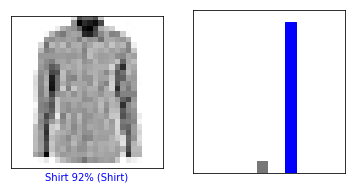

In [36]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

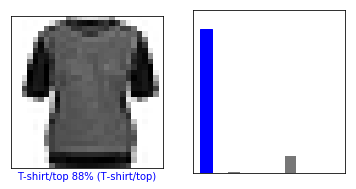

In [37]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

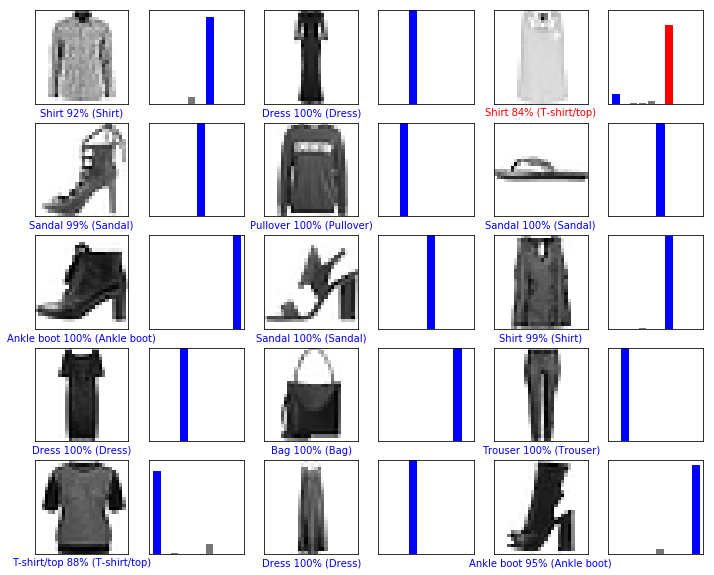

In [40]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [41]:
# Grab an image form the test dataset
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [42]:
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [43]:
predictions_single = model.predict(img)
print(predictions_single)

[[4.15152218e-10 1.85740312e-12 1.38368574e-04 3.91565391e-10
  7.51407146e-02 1.04985473e-11 9.24720943e-01 1.02567434e-10
  1.15748210e-11 1.54871826e-09]]


In [44]:
np.argmax(predictions_single[0])

6